# Аналитика в Яндекс.Афише

 С помощью данных о визитах, покупках и расходах на рекламу требуется провести когортный анализ
для основных метрик продукта (LTV, CAC, ROI, Retention Rate), изучить как можно оптимизировать
маркетинговые затраты.  
У вас в распоряжении есть данные от Яндекс.Афиши с июня 2017 по конец мая 2018 года:
- лог сервера с данными о посещениях сайта Яндекс.Афиши,
- выгрузка всех заказов за этот период,
- статистика рекламных расходов.


### Описание данных

Лог сервера с информацией о посещениях сайта:  
- id пользователя  
- категория устройства пользователя  
- дата и время начала сессии  
- дата и время окончания сессии  
- id рекламного источника, из которого пришел пользователь  

Информация о заказах:  
- id пользователя, который сделал заказ  
- дата и время заказа  
- выручка Яндекс.Афиши с этого заказа  

Информация о затратах на маркетинг:  
- id рекламного источника  
- дата  
- затраты на этот рекламный источник в этот день 

### План проекта:  
[Шаг 1. Загрузка данных и подготовка к анализу](#step1)  
[Шаг 2. Построение отчетов и подсчет метрик](#step2)  
- [Продукт](#step2.1)  
- [Продажи](#step2.2)  
- [Маркетинг](#step2.3)    

[Шаг 3. Рекомендации маркетологам](#step3)  

### <a id="step1"> Шаг 1. Загрузка данных и подготовка к анализу</a>

Напишем функцию для пути файла, чтобы файл открывался и на локальном компьютере, и в практикуме

In [1]:
import os
def try_path(path):
    if os.path.exists(path):
        return path
    else:
        return "." + path

Подключим библиотеки, которые нам потребуются в дальнейшем

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
import seaborn as sns

Создадим dataframe c информаций о расходах. Посмотрим 5 случайных записей из него

In [3]:
costs = pd.read_csv(try_path('/datasets/costs.csv'))
costs.sample(5)

,source_id,dt,costs
1325,4,2018-01-23,11.67
2471,10,2018-03-20,29.10
1522,5,2017-08-10,79.18
711,2,2018-05-17,70.77
435,2,2017-08-12,36.05


Создадим dataframe c информаций о расходах. Посмотрим 5 случайных записей из него

In [4]:
orders = pd.read_csv(try_path('/datasets/orders_log.csv'))
orders.sample(5)

,Buy Ts,Revenue,Uid
6852,2017-09-05 08:53:00,12.22,9727030316029015991
30616,2018-01-23 11:07:00,1.83,17961312288474017301
1226,2017-06-10 11:46:00,0.92,1670885727719918667
18405,2017-11-19 16:22:00,2.44,3940238453190104021
45189,2018-04-23 16:03:00,2.20,6166747268563050393


Создадим dataframe c информаций о посещениях. Посмотрим 5 случайных записей из него

In [5]:
visits = pd.read_csv(try_path('/datasets/visits_log.csv'))
visits.sample(5)

,Device,End Ts,Source Id,Start Ts,Uid
318256,touch,2017-11-17 21:47:00,4,2017-11-17 21:44:00,16221129647600163867
133748,touch,2018-01-19 18:10:00,4,2018-01-19 18:04:00,15784920699928937996
77221,touch,2017-09-29 15:55:00,5,2017-09-29 15:54:00,8873900374388997214
187680,desktop,2017-09-28 21:07:00,5,2017-09-28 21:07:00,17096161305285090248
20308,desktop,2017-08-09 13:08:00,2,2017-08-09 13:05:00,3182101868319098230


Переименуем столбцы для удобства работы с данными в дальнейшем

In [6]:
costs.columns = ['source_id','date','costs']
orders.columns = ['date','revenue','uid']
visits.columns = ['device','visit_end_date','source_id','visit_start_date', 'uid']

Посмотрим информацию о таблицах

In [7]:
datasets = {'costs':costs, 'orders':orders, 'visits':visits}

for k in datasets:
    print(k)
    print(datasets[k].info())
    print()

costs
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
date         2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB
None

orders
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
date       50415 non-null object
revenue    50415 non-null float64
uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB
None

visits
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
device              359400 non-null object
visit_end_date      359400 non-null object
source_id           359400 non-null int64
visit_start_date    359400 non-null object
uid                 359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB
None



Видно, что все даты представлены строками в таблицах. Приведем их к типу данных datetime

In [8]:
cols_to_convert = ((costs, 'date'), (orders, 'date'), (visits, 'visit_start_date'), (visits, 'visit_end_date'))
for df, col in cols_to_convert:
    df[col] = pd.to_datetime(df[col])

Добавим в таблицу costs месяц даты, когда были произведены затраты на маркетинг. Нам эти данные потребуются при дальнейшем анализе

In [9]:
costs['month'] = costs['date'].astype('datetime64[M]')
costs.head()

,source_id,date,costs,month
0,1,2017-06-01,75.20,2017-06-01
1,1,2017-06-02,62.25,2017-06-01
2,1,2017-06-03,36.53,2017-06-01
3,1,2017-06-04,55.00,2017-06-01
4,1,2017-06-05,57.08,2017-06-01


Добавим в таблицу orders день, месяц и неделю для каждой записи даты заказа. Нам эти данные потребуются при дальнейшем анализе

In [10]:
orders['day'] = orders['date'].astype('datetime64[D]')
orders['month'] = orders['date'].astype('datetime64[M]')
orders['week'] = orders['date'].astype('datetime64[W]')
orders.head()

,date,revenue,uid,day,month,week
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01,2017-06-01


Добавим в таблицу visits день, месяц, неделю даты начала сессии

In [11]:
visits['visit_day'] = visits['visit_start_date'].astype('datetime64[D]')
visits['visit_week'] = visits['visit_start_date'].astype('datetime64[W]')
visits['visit_month'] = visits['visit_start_date'].astype('datetime64[M]')
visits.head()

,device,visit_end_date,source_id,visit_start_date,uid,visit_day,visit_week,visit_month
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,2017-12-14,2017-12-01
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,2018-02-15,2018-02-01
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,2017-06-29,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,2018-05-17,2018-05-01
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-27,2017-12-21,2017-12-01


### Вывод

Звгрузили данные о заказах, сессиях и затратах на маркетинг. Преобразовали даты к типу данных datetime. Добавили в таблицы составные части дат (день, неделя, месяц) для более удобного дальнейшего анализа

### <a id="step2"> Шаг 2. Построение отчетов и подсчет метрик</a>

### - <a id="step2.1"> Продукт</a>

- Сколько людей пользуются в день, неделю, месяц?

Сгруппируем данные по дням/ неделям/ месяцам и посчитаем количество уникальных пользователей в выбранный период 

In [12]:
dau = visits.groupby('visit_day').agg({'uid':'nunique'}).reset_index().mean()
wau = visits.groupby('visit_week').agg({'uid':'nunique'}).reset_index().mean()
mau = visits.groupby('visit_month').agg({'uid':'nunique'}).reset_index().mean()

print('Среднее количество уникальных пользователей в день:',int(dau))
print('Среднее количество уникальных пользователей в неделю:',int(wau))
print('Среднее количество уникальных пользователей в месяц:',int(mau))

Среднее количество уникальных пользователей в день: 907
Среднее количество уникальных пользователей в неделю: 5724
Среднее количество уникальных пользователей в месяц: 23228


Посмотрим сколько заходов было с каждого из девайсов

In [13]:
visits.pivot_table(index = ['device'], values = 'uid', aggfunc = 'nunique')

,device,uid
device,,
desktop,1,164523
touch,1,71345


Выяснили, что:
- Среднее количество уникальных пользователей в день: 907
- Среднее количество уникальных пользователей в неделю: 5724
- Среднее количество уникальных пользователей в месяц: 23228
- Уникальных заходов с компьютера было больше в 2.3 раза чем с телефона

- Сколько сессий в день?

Посчитаем сколько сессий в день приходится на одного пользователя

In [14]:
visits_per_person_per_day = visits.groupby(['uid','visit_day']).size()
visits_per_person_per_day.head()

uid              visit_day 
11863502262781   2018-03-01    1
49537067089222   2018-02-06    1
297729379853735  2017-06-07    1
313578113262317  2017-09-18    1
                 2018-02-18    1
dtype: int64

Построим график распределения количества визитов

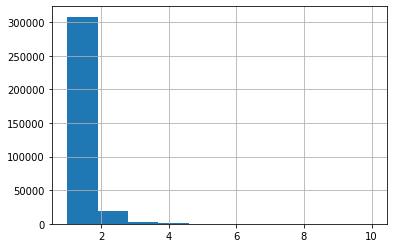

In [15]:
visits_per_person_per_day.hist();

В среднем пользователь совершает одну сессию в день

- Сколько длится одна сессия?

Посчитаем в секундах сколько длилалась каждая сессия. Посмотрим описательные статистики по получившимся данным

In [16]:
visits['duration'] = (visits['visit_end_date'] - visits['visit_start_date']).dt.seconds
visits.groupby('device')['duration'].describe()

,count,mean,std,min,25%,50%,75%,max
device,,,,,,,,
desktop,262567.0,703.946977,1091.545596,0.0,120.0,360.0,900.0,84480.0
touch,96833.0,479.619407,752.531533,0.0,60.0,180.0,600.0,30840.0


Станадартное отклонение очень велико. Будем использовать в качестве меры центральной тенденции для описания наших данных моду

In [17]:
int(visits['duration'].mode())

60

Построим медиану длительности сессии по типу устройства

In [18]:
print(visits.query('device == "desktop"')['duration'].median())
print(visits.query('device == "touch"')['duration'].median())

360.0
180.0


Одна сессия длится в среднем минуту. В среднем сессии с компьютера длиннее чем с телефона в 2 раза

- Как часто люди возвращаются?

Разобьем наших пользователей на когорты. В качестве целевого события возьмем первый заход в наш сервис. В качестве периода возьмем месяц. Для каждой из когорт рассчитаем retention rate относительно времени жизни когорты. Это позволит нам понять как часто люди возвращаются в наш сервис

Посчитаем для каждого из пользователей в какой месяц они совершили первый заход на наш сервис

In [19]:
first_visit_by_user =  visits.groupby('uid').agg({'visit_month':'min','visit_start_date':'min'}).reset_index()
first_visit_by_user.columns = ['uid', 'first_visit_month', 'first_visit_date']
first_visit_by_user.head()

,uid,first_visit_month,first_visit_date
0,11863502262781,2018-03-01,2018-03-01 17:27:00
1,49537067089222,2018-02-01,2018-02-06 15:55:00
2,297729379853735,2017-06-01,2017-06-07 18:47:00
3,313578113262317,2017-09-01,2017-09-18 22:49:00
4,325320750514679,2017-09-01,2017-09-30 14:29:00


Добавим в таблицу с визитами информацию о том в какой месяц пользователь совершил первый заход на наш сервис

In [20]:
visits = visits.merge(first_visit_by_user, on = 'uid')
visits.head()

,device,visit_end_date,source_id,visit_start_date,uid,visit_day,visit_week,visit_month,duration,first_visit_month,first_visit_date
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,2017-12-14,2017-12-01,1080,2017-12-01,2017-12-20 17:20:00
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,2018-02-15,2018-02-01,1680,2018-02-01,2018-02-19 16:53:00
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,2017-06-29,2017-07-01,0,2017-07-01,2017-07-01 01:54:00
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,2018-05-17,2018-05-01,1440,2018-03-01,2018-03-09 20:05:00
4,desktop,2018-03-09 20:33:00,4,2018-03-09 20:05:00,16174680259334210214,2018-03-09,2018-03-08,2018-03-01,1680,2018-03-01,2018-03-09 20:05:00


Посчитаем сколько месяцев прошло между первым визитом и текушим визитом для каждой записи в таблице с визитами

In [21]:
visits['age'] = (visits['visit_month'].dt.year - visits['first_visit_month'].dt.year) * 12 + \
    (visits['visit_month'].dt.month - visits['first_visit_month'].dt.month)

visits.head()

,device,visit_end_date,source_id,visit_start_date,uid,visit_day,visit_week,visit_month,duration,first_visit_month,first_visit_date,age
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,2017-12-14,2017-12-01,1080,2017-12-01,2017-12-20 17:20:00,0
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,2018-02-15,2018-02-01,1680,2018-02-01,2018-02-19 16:53:00,0
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,2017-06-29,2017-07-01,0,2017-07-01,2017-07-01 01:54:00,0
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,2018-05-17,2018-05-01,1440,2018-03-01,2018-03-09 20:05:00,2
4,desktop,2018-03-09 20:33:00,4,2018-03-09 20:05:00,16174680259334210214,2018-03-09,2018-03-08,2018-03-01,1680,2018-03-01,2018-03-09 20:05:00,0


Построим сводную таблицу, где для каждой когорты будет показано количество уникальных пользователей относительно времени жизни когорты, выраженнной в месяцах

In [22]:
visits_monthly_cohorts = visits.pivot_table(index = 'first_visit_month', columns = 'age', values = 'uid', aggfunc = 'nunique')
visits_monthly_cohorts

age,0,1,2,3,4,5,6,7,8,9,10,11
first_visit_month,,,,,,,,,,,,
2017-06-01,13259.0,1043.0,713.0,814.0,909.0,947.0,809.0,766.0,694.0,674.0,539.0,596.0
2017-07-01,13140.0,737.0,674.0,738.0,765.0,633.0,596.0,601.0,510.0,376.0,361.0,NaN
2017-08-01,10181.0,783.0,640.0,639.0,510.0,448.0,370.0,402.0,284.0,265.0,NaN,NaN
2017-09-01,16704.0,1428.0,1156.0,847.0,658.0,632.0,599.0,404.0,381.0,NaN,NaN,NaN
2017-10-01,25977.0,2042.0,1357.0,1012.0,890.0,837.0,555.0,529.0,NaN,NaN,NaN,NaN
2017-11-01,27248.0,2133.0,1202.0,1054.0,919.0,638.0,594.0,NaN,NaN,NaN,NaN,NaN
2017-12-01,25268.0,1410.0,960.0,786.0,512.0,481.0,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,22624.0,1351.0,890.0,565.0,458.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,22197.0,1267.0,565.0,446.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Посчитаем retention rate для каждой из когорт относительно времени жизни когорты

In [23]:
def count_retention_rate(row):
    users_qty_0_lifetime = row[0]
    res_row = []
    for element in row:
        element = round(element / users_qty_0_lifetime,2)
        res_row.append(element)
    return pd.Series(res_row) 
    
visits_monthly_cohorts = visits_monthly_cohorts.apply(count_retention_rate,axis = 1)
visits_monthly_cohorts.index = visits_monthly_cohorts.index.date
visits_monthly_cohorts

,0,1,2,3,4,5,6,7,8,9,10,11
2017-06-01,1.0,0.08,0.05,0.06,0.07,0.07,0.06,0.06,0.05,0.05,0.04,0.04
2017-07-01,1.0,0.06,0.05,0.06,0.06,0.05,0.05,0.05,0.04,0.03,0.03,NaN
2017-08-01,1.0,0.08,0.06,0.06,0.05,0.04,0.04,0.04,0.03,0.03,NaN,NaN
2017-09-01,1.0,0.09,0.07,0.05,0.04,0.04,0.04,0.02,0.02,NaN,NaN,NaN
2017-10-01,1.0,0.08,0.05,0.04,0.03,0.03,0.02,0.02,NaN,NaN,NaN,NaN
2017-11-01,1.0,0.08,0.04,0.04,0.03,0.02,0.02,NaN,NaN,NaN,NaN,NaN
2017-12-01,1.0,0.06,0.04,0.03,0.02,0.02,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,1.0,0.06,0.04,0.02,0.02,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,1.0,0.06,0.03,0.02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01,1.0,0.04,0.03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Построим heatmap для наших данных

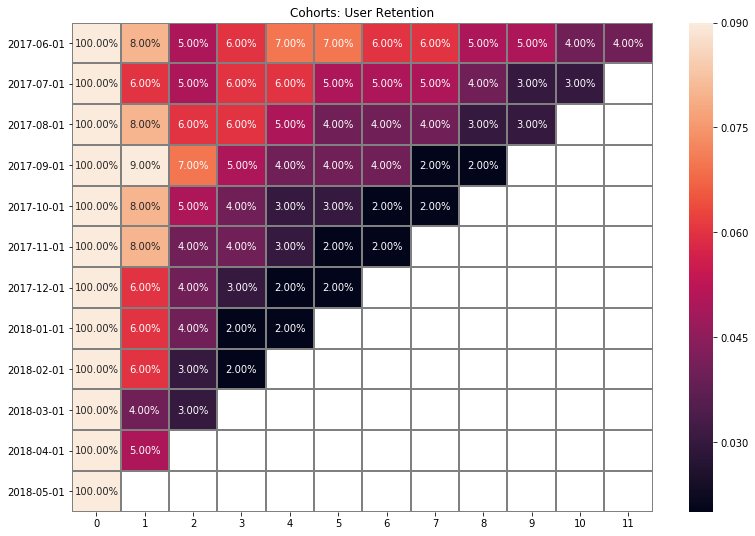

In [24]:
plt.figure(figsize=(13, 9))
plt.title('Cohorts: User Retention')
sns.heatmap(visits_monthly_cohorts, annot=True, fmt='.2%', linewidths=1, linecolor='gray', vmax = 0.09);

- На второй месяц после первого использования возвращается примерно 6 % пользователей, дальше в основном он становится ниже или держится какое-то время на тоже уровне
- Самый высокий retention rate произошел у сентябрьской когорты 2017 в октябре и был равен 9 %
- У пользователей, которые присоединились в июне 2017, самый высокий retetion rate на протяжении всего времени жизни когорты
- Начиная с когорты 01.09.2017 и дальше период времени, когда у когорты был бы высокий Retetion rate, с каждой когортой все короче

### Вывод

Выяснили, что:
- Среднее количество уникальных пользователей в день: 907
- Среднее количество уникальных пользователей в неделю: 5724
- Среднее количество уникальных пользователей в месяц: 23228
- Уникальных заходов с компьютера было больше в 2.3 раза чем с телефона
- В среднем пользователь совершает одну сессию в день
- Одна сессия длится в среднем минуту. В среднем сессии с компьютера длиннее чем с телефона в 2 раза
- На второй месяц после первого использования возвращается примерно 6 % пользователей
- Самый высокий retention rate произошел у сентябрьской когорты 2017 в октябре и был равен 9 %
- У пользователей, которые присоединились в июне 2017, самый высокий retetion rate на протяжении всего времени жизни когорты
- Начиная с когорты 01.09.2017 и дальше период времени, когда у когорты был бы высокий Retetion rate с каждой когортой все короче

### - <a id="step2.2"> Продажи</a>

- Когда люди начинают покупать?

Посчитаем для каждого из пользователей дату первой покупки

In [25]:
orders_by_uid = orders.groupby('uid').agg({'day':'min'}).reset_index()
orders_by_uid.columns = ['uid','first_order_day']
orders_by_uid.head()

,uid,first_order_day
0,313578113262317,2018-01-03
1,1575281904278712,2017-06-03
2,2429014661409475,2017-10-11
3,2464366381792757,2018-01-28
4,2551852515556206,2017-11-24


Посчитаем день первой сессии для каждого из пользователей

In [26]:
first_visit_by_user_day =  visits.groupby('uid').agg({'visit_day':'min'}).reset_index()
first_visit_by_user_day.columns = ['uid', 'first_visit_day']
first_visit_by_user_day.head()

,uid,first_visit_day
0,11863502262781,2018-03-01
1,49537067089222,2018-02-06
2,297729379853735,2017-06-07
3,313578113262317,2017-09-18
4,325320750514679,2017-09-30


Добавим в таблицу orders_by_uid время первой покупки

In [27]:
orders_by_uid = orders_by_uid.merge(first_visit_by_user_day, on = 'uid')
orders_by_uid.head()

,uid,first_order_day,first_visit_day
0,313578113262317,2018-01-03,2017-09-18
1,1575281904278712,2017-06-03,2017-06-03
2,2429014661409475,2017-10-11,2017-10-11
3,2464366381792757,2018-01-28,2018-01-27
4,2551852515556206,2017-11-24,2017-11-24


Посчитаем сколько дней проходит между первым визитом и первой покупкой

In [28]:
orders_by_uid['time_between_visit_and_order'] = (orders_by_uid['first_order_day'] - orders_by_uid['first_visit_day']).dt.days
orders_by_uid.head()

,uid,first_order_day,first_visit_day,time_between_visit_and_order
0,313578113262317,2018-01-03,2017-09-18,107
1,1575281904278712,2017-06-03,2017-06-03,0
2,2429014661409475,2017-10-11,2017-10-11,0
3,2464366381792757,2018-01-28,2018-01-27,1
4,2551852515556206,2017-11-24,2017-11-24,0


Посмотрим описательные статистики по полученной таблице

In [29]:
orders_by_uid['time_between_visit_and_order'].describe()

count    36523.000000
mean        16.895901
std         47.071200
min          0.000000
25%          0.000000
50%          0.000000
75%          2.000000
max        363.000000
Name: time_between_visit_and_order, dtype: float64

В основном люди совершают свой первый заказ в тот же день, что и первый раз зашли в сервис. Редко время между заходом и заказом составляет более двух дней

- Сколько раз покупают за период?

Посчитаем сколько покупок было совершено в каждый день, месяц и день

In [30]:
orders_groupby_month = orders.groupby('month').size().reset_index()
orders_groupby_month.columns = ['month', 'orders_qty']
orders_groupby_week = orders.groupby('week').size().reset_index()
orders_groupby_week.columns = ['week', 'orders_qty']
orders_groupby_day = orders.groupby('day').size().reset_index()
orders_groupby_day.columns = ['day', 'orders_qty']

Построим графики, чтобы посмотреть, когда у нас были пики и спады в продажах

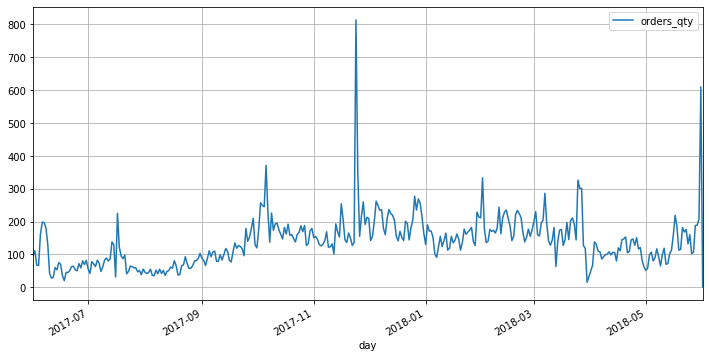

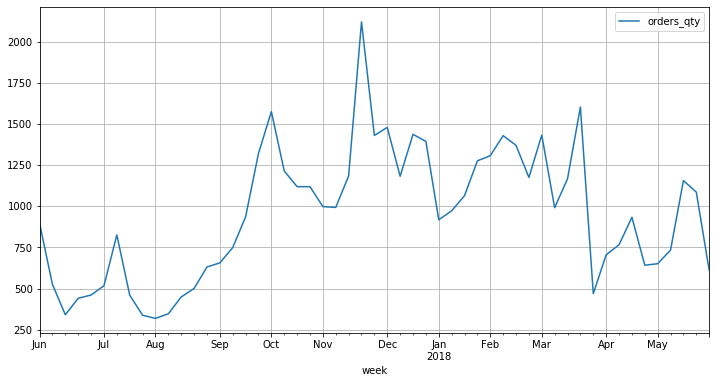

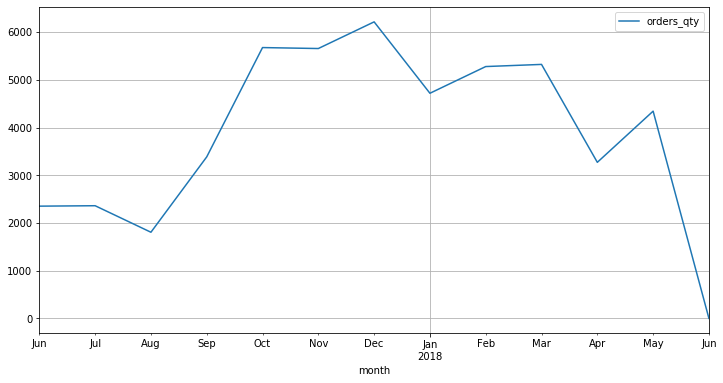

In [31]:
orders_groupby_day.plot(kind = 'line', x = 'day', y= 'orders_qty', grid = True, figsize = (12,6));
orders_groupby_week.plot(kind = 'line',  x = 'week', y= 'orders_qty', grid = True, figsize = (12,6));
orders_groupby_month.plot(kind = 'line', x = 'month', y= 'orders_qty', grid = True, figsize = (12,6));

Посмотрим среднее количество покупок в день, неделю и месяц

In [64]:
print('В среднем в день совершают {} покупок'.format(round(orders_groupby_day['orders_qty'].mean())))
print('В среднем в неделю совершают {} покупок'.format(round(orders_groupby_week['orders_qty'].mean())))
print('В среднем в месяц совершают {} покупок'.format(round(orders_groupby_month['orders_qty'].mean())))

В среднем в день совершают 139 покупок
В среднем в неделю совершают 951 покупок
В среднем в месяц совершают 3878 покупок


В среднем в день совершают 139 покупок  
В среднем в неделю совершают 951 покупок  
В среднем в месяц совершают 3878 покупок  
Больше всего покупок было совершено в период с октября по декабрь и в этом периоде самый большой пик в количестве покупок был за две недели до нового года.  
Меньше всего покупок было совершено летом

- Какой средний чек?

Посчитаем сумму покупок за каждый день, неделю, месяц 

In [33]:
revenue_by_day = orders.groupby('day').agg({'revenue':'sum'}).reset_index()
revenue_by_week = orders.groupby('week').agg({'revenue':'sum'}).reset_index()
revenue_by_month = orders.groupby('month').agg({'revenue':'sum'}).reset_index()

Добавим информацию о сумме покупок в таблицы с заказами сгруппироваными по дням/неделям/месяцам

In [34]:
orders_groupby_day = orders_groupby_day.merge(revenue_by_day, on = 'day') 
orders_groupby_week = orders_groupby_week.merge(revenue_by_week, on = 'week')
orders_groupby_month = orders_groupby_month.merge(revenue_by_month, on = 'month') 

Посчитаем средний чек в разрезе дня, недели, месяца

In [35]:
orders_groupby_day['average_check'] = round(orders_groupby_day['revenue'] / orders_groupby_day['orders_qty'], 2)
orders_groupby_week['average_check'] = round(orders_groupby_week['revenue'] / orders_groupby_week['orders_qty'], 2)
orders_groupby_month['average_check'] = round(orders_groupby_month['revenue'] / orders_groupby_month['orders_qty'], 2)

Построим графики, чтобы посмотреть, когда у нас были пики и спады в среднем чеке

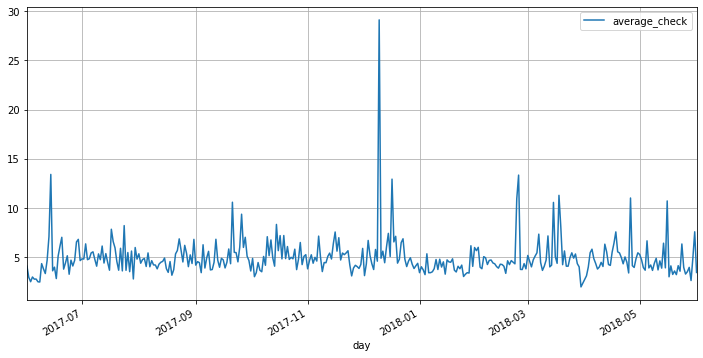

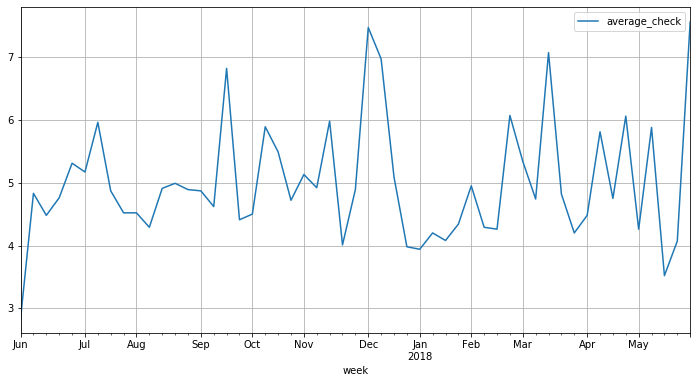

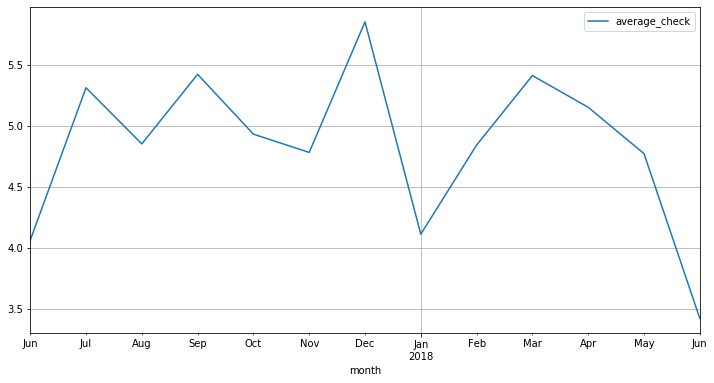

In [36]:
orders_groupby_day.plot(kind = 'line', x = 'day', y= 'average_check', grid = True, figsize = (12,6));
orders_groupby_week.plot(kind = 'line',  x = 'week', y= 'average_check', grid = True, figsize = (12,6));
orders_groupby_month.plot(kind = 'line', x = 'month', y= 'average_check', grid = True, figsize = (12,6));

Посмотрим средний чек в разрезе дня

Посмотрим описательные статистики по среднему чеку в разрезе дня

In [37]:
orders_groupby_day['average_check'].describe()

count    364.000000
mean       4.936236
std        2.021761
min        1.950000
25%        3.960000
50%        4.560000
75%        5.410000
max       29.130000
Name: average_check, dtype: float64

Средний чек составляет около 5 у.е.. 
Средний чек в начале месяца выше чем в конце месяца кроме декабря, там пик приходится на конец месяца.
Самый высокий средний чек был в середине сентября, конце августа и середине марта
Самый низкий средний чек был в конце января и начале февраля

- Сколько денег приносят? 

Добавим в таблицу orders информацию о дате первой покупки

In [38]:
orders = orders.merge(orders_by_uid[['uid','first_order_day']], on = 'uid')
orders.head()

,date,revenue,uid,day,month,week,first_order_day
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01,2017-06-01,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01,2017-06-01,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01,2017-06-01,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01,2017-06-01,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01,2017-06-01,2017-06-01


Добавим в нашу таблицу информацию о месяце первой покупки

In [39]:
orders['first_order_month'] = orders['first_order_day'].astype('datetime64[M]')
orders.head()

,date,revenue,uid,day,month,week,first_order_day,first_order_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01,2017-06-01,2017-06-01,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01,2017-06-01,2017-06-01,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01,2017-06-01,2017-06-01,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01,2017-06-01,2017-06-01,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01,2017-06-01,2017-06-01,2017-06-01


Поделим наших пользователей на когороты по первому месяцу покупки и будем смотреть доход помесячно 

In [40]:
orders_cohorts_months = orders.groupby(['first_order_month','month']).agg({'revenue':'sum'}).reset_index()
orders_cohorts_months.head()

,first_order_month,month,revenue
0,2017-06-01,2017-06-01,9557.49
1,2017-06-01,2017-07-01,981.82
2,2017-06-01,2017-08-01,885.34
3,2017-06-01,2017-09-01,1931.30
4,2017-06-01,2017-10-01,2068.58


Посчитаем сколько покупателей было в каждый из месяцев

In [41]:
buyers_by_month = orders.groupby('first_order_month').agg({'uid':'nunique'}).reset_index()
buyers_by_month.columns = ['first_order_month','buyers_qty']
buyers_by_month.head()

,first_order_month,buyers_qty
0,2017-06-01,2023
1,2017-07-01,1923
2,2017-08-01,1370
3,2017-09-01,2581
4,2017-10-01,4340


Добавим в таблицу orders_cohorts_months информацию о количестве покупателей

In [42]:
orders_cohorts_months = orders_cohorts_months.merge(buyers_by_month, on = 'first_order_month')
orders_cohorts_months.head()

,first_order_month,month,revenue,buyers_qty
0,2017-06-01,2017-06-01,9557.49,2023
1,2017-06-01,2017-07-01,981.82,2023
2,2017-06-01,2017-08-01,885.34,2023
3,2017-06-01,2017-09-01,1931.30,2023
4,2017-06-01,2017-10-01,2068.58,2023


Посчитаем среднюю выручку на пользователя для каждой из когорт и времени жизни когорты

In [43]:
orders_cohorts_months['ltv'] = round(orders_cohorts_months['revenue'] / orders_cohorts_months['buyers_qty'],2)
orders_cohorts_months.head()

,first_order_month,month,revenue,buyers_qty,ltv
0,2017-06-01,2017-06-01,9557.49,2023,4.72
1,2017-06-01,2017-07-01,981.82,2023,0.49
2,2017-06-01,2017-08-01,885.34,2023,0.44
3,2017-06-01,2017-09-01,1931.30,2023,0.95
4,2017-06-01,2017-10-01,2068.58,2023,1.02


Посчитаем для каждой из записей время жизни когорты

In [44]:
orders_cohorts_months['cohort_age'] = orders_cohorts_months['month'].dt.month - orders_cohorts_months['first_order_month'].dt.month \
                                      + (orders_cohorts_months['month'].dt.year - orders_cohorts_months['first_order_month'].dt.year) * 12
orders_cohorts_months.head()

,first_order_month,month,revenue,buyers_qty,ltv,cohort_age
0,2017-06-01,2017-06-01,9557.49,2023,4.72,0
1,2017-06-01,2017-07-01,981.82,2023,0.49,1
2,2017-06-01,2017-08-01,885.34,2023,0.44,2
3,2017-06-01,2017-09-01,1931.30,2023,0.95,3
4,2017-06-01,2017-10-01,2068.58,2023,1.02,4


Развернем таблицу с ltv по когортам, чтобы было удобнее

In [45]:
orders_cohorts_months_pivot = orders_cohorts_months.pivot_table(index = 'first_order_month', columns = 'cohort_age', values = 'ltv', aggfunc = 'mean').round()
orders_cohorts_months_pivot

cohort_age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,5.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
2017-07-01,6.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2017-08-01,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
2017-09-01,6.0,1.0,1.0,4.0,0.0,1.0,1.0,0.0,0.0,NaN,NaN,NaN
2017-10-01,5.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
2017-11-01,5.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2017-12-01,5.0,0.0,1.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,4.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,4.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Посмотрим сколько в каждый из месяцев был равен суммарный ltv по всем когортам

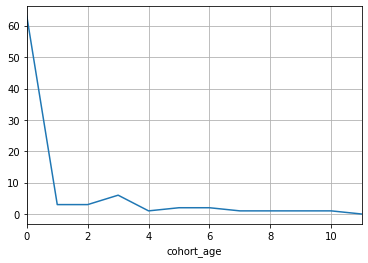

In [46]:
orders_cohorts_months_pivot.apply(lambda x: x.sum()).plot(kind = 'line', grid = True);

Посмотрим ltv по когортам

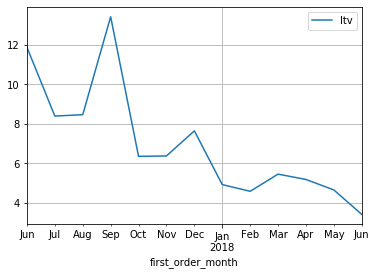

In [47]:
orders_cohorts_months.groupby('first_order_month').agg({'ltv':'sum'}).reset_index().plot(kind = 'line', grid = True, x = 'first_order_month');

В среднем каждый покупатель приносит основную прибыль в первый месяц своего присоединения к сервису. Только сентябрьская когорта принесла сравнимо прибыли на человека в декабре с первым месяцем (сентябрем).
В первый месяц присоединения один клиент приносит в среднем 5 у.е., в последуюшие месяцы приносит или ничего, или 1 у.е в среднем.
Больше всего прибыли на клиента принесла сентябрьская когорта

Посмотрим сколько в среднем приносит один покупатель в разрезе источников привлечения

Посчитаем из какого источника был привлечени каждый из пользователей в первый раз. Добавим эту информацию в таблицу с визитами

In [48]:
first_source_id = visits.query('visit_start_date == first_visit_date')[['uid','source_id']]
first_source_id.columns = ['uid','first_source_id']
orders = orders.merge(first_source_id, on = 'uid')
orders.head()

,date,revenue,uid,day,month,week,first_order_day,first_order_month,first_source_id
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01,2017-06-01,2017-06-01,2017-06-01,1
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01,2017-06-01,2017-06-01,2017-06-01,2
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01,2017-06-01,2017-06-01,2017-06-01,2
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01,2017-06-01,2017-06-01,2017-06-01,2
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01,2017-06-01,2017-06-01,2017-06-01,3


Посчитаем для каждого источника сколько было покупателей и сколько выручки они принеслию Посчитаем ltv для каждого из источников

In [49]:
info_by_source = orders.groupby('first_source_id').agg({'revenue':'sum', 'uid':'nunique'}).reset_index()
info_by_source.columns = ['source_id', 'revenue', 'buyers_qty']
info_by_source['ltv'] = round(info_by_source['revenue'] / info_by_source['buyers_qty'],2)
info_by_source.sort_values(by = 'ltv')

,source_id,revenue,buyers_qty,ltv
5,7,1.22,1,1.22
7,10,4450.33,1329,3.35
2,3,54511.24,10473,5.20
6,9,5759.40,1088,5.29
3,4,56696.83,10296,5.51
4,5,52624.02,6931,7.59
0,1,31090.55,2899,10.72
1,2,46923.61,3506,13.38


Наибольшую выручку с покупателя приносит источник 2 - 13,38 у.е, наименьшую - источник 7 - 1,22 у.е

### Вывод

В основном люди совершают свой первый заказ в тот же день, что и первый раз зашли в сервис. Редко время между заходом и заказом составляет более двух дней. В среднем в день совершают 139 покупок, в неделю - 951 покупок, в месяц - 3878 покупок
Больше всего покупок было совершено в период с октября по декабрь и в этом периоде самый большой пик покуопк был за две недеи до нового года. Меньше всего покупок было совершено летом.  

Средний чек составляет около 5 у.е. Средний чек в начале месяца выше чем в конце месяца кроме декабря, там пик приходится на конец месяца.Самый высокий средний чек был в середине сентября, конце августа и середине марта. Самый низкий средний чек был в конце января и начале февраля

Наибольшую выручку с покупателя приносит источник 2 - 13,38 у.е., наименьшую - источник 7 - 1,22 у.е.
В среднем каждый покупатель приносит основную прибыль в первый месяц своего присоединения к сервису. Только сентябрьская когорта принесла сравнимо прибыли на человека в декабре с первым месяцем (сентябрем)
В первый месяц присоединения один клиент приносит в среднем 5 у.е., в последуюшие месяцы приносит или ничего, или 1 у.е в среднем.
Больше всего прибыли на клиента принесла сентябрьская когорта

### - <a id="step2.3"> Маркетинг</a>

- Сколько денег потратили? Всего / на каждый источник / по времени

Посчитаем сколько денег потратили всего, в разрезе источника, в каждый месяц

In [50]:
costs_total = costs['costs'].sum()
costs_by_source = costs.groupby('source_id').agg({'costs':'sum'}).reset_index()
costs_by_month = costs.groupby('month').agg({'costs':'sum'}).reset_index()

display(costs_total)
display(costs_by_source.sort_values(by = 'costs'))
display(costs_by_month.sort_values(by = 'costs'))


329131.62

,source_id,costs
5,9,5517.49
6,10,5822.49
0,1,20833.27
1,2,42806.04
4,5,51757.10
3,4,61073.60
2,3,141321.63


,month,costs
2,2017-08-01,14790.54
0,2017-06-01,18015.00
1,2017-07-01,18240.59
11,2018-05-01,22224.27
10,2018-04-01,22289.38
3,2017-09-01,24368.91
9,2018-03-01,30415.27
8,2018-02-01,32723.03
7,2018-01-01,33518.52
4,2017-10-01,36322.88


Посчитаем среднее по источнику и месяцу

In [51]:
print('Затраты в среднем на один источник:', round(costs_by_source['costs'].mean()))
print('Затраты в среднем в месяц:', round(costs_by_month['costs'].mean()))

Затраты в среднем на один источник: 47019
Затраты в среднем в месяц: 27428


Всего на привлечение пользователей потратили 329131  у.е. В среднем в месяц тратим на привлечение - 27428 у.е. В среднем потратили на привлечение из одного источника 47019 у.е. Больше всего потратили на привлечение пользователей через источник 3, меньше всего на источник 9. Больше всего потратили на привлечение пользователей в декабре и меньше всего в августе. 

- Сколько стоило привлечение одного покупателя из каждого источника?

В предыдущем шаге мы уже посчитали сколько пользователей из какого источника пришли (таблица info_by_source). Добавим в эту таблицу информацию  о том сколько мы потратили на каждый из источников

In [52]:
info_by_source =  info_by_source.merge(costs_by_source, on = 'source_id')
info_by_source

,source_id,revenue,buyers_qty,ltv,costs
0,1,31090.55,2899,10.72,20833.27
1,2,46923.61,3506,13.38,42806.04
2,3,54511.24,10473,5.20,141321.63
3,4,56696.83,10296,5.51,61073.60
4,5,52624.02,6931,7.59,51757.10
5,9,5759.40,1088,5.29,5517.49
6,10,4450.33,1329,3.35,5822.49


Посчитаем сколько нужно было потратить на привлечение одного пользователя

In [53]:
info_by_source['cac'] = round(info_by_source['costs'] / info_by_source['buyers_qty'],2)
info_by_source.sort_values(by = 'cac')

,source_id,revenue,buyers_qty,ltv,costs,cac
6,10,4450.33,1329,3.35,5822.49,4.38
5,9,5759.40,1088,5.29,5517.49,5.07
3,4,56696.83,10296,5.51,61073.60,5.93
0,1,31090.55,2899,10.72,20833.27,7.19
4,5,52624.02,6931,7.59,51757.10,7.47
1,2,46923.61,3506,13.38,42806.04,12.21
2,3,54511.24,10473,5.20,141321.63,13.49


Посмотрим описательные статистики по CAC

In [54]:
info_by_source['cac'].describe()

count     7.000000
mean      7.962857
std       3.530008
min       4.380000
25%       5.500000
50%       7.190000
75%       9.840000
max      13.490000
Name: cac, dtype: float64

В среднем тратим на привлечение одного пользователя 8 у.е. Больше всего стоит привлечение одного пользователя через источник 2 , меньше всего - через источник 10

- На сколько окупились расходы? (ROI)

Сгруппируем заказы для каждого источника по месяцу первой покупки и месяцу каждого заказа и посчитаем суммарныую выручку.  
Сгруппируем затраты по источнику и посмотрим сколько было потрачено в каждый их месяцев

In [55]:
revenue_by_source_and_month = orders.groupby(['first_source_id','first_order_month','month']).agg({'revenue':'sum'}).reset_index()
revenue_by_source_and_month.columns = ['source_id', 'first_order_month', 'month','revenue']
costs_by_source_and_month = costs.groupby(['source_id','month']).agg({'costs':'sum'}).reset_index()
costs_by_source_and_month.columns = ['source_id', 'first_order_month', 'costs']
display(revenue_by_source_and_month.head())
display(costs_by_source_and_month.head())

,source_id,first_order_month,month,revenue
0,1,2017-06-01,2017-06-01,1378.70
1,1,2017-06-01,2017-07-01,414.98
2,1,2017-06-01,2017-08-01,419.43
3,1,2017-06-01,2017-09-01,714.24
4,1,2017-06-01,2017-10-01,811.20


,source_id,first_order_month,costs
0,1,2017-06-01,1125.61
1,1,2017-07-01,1072.88
2,1,2017-08-01,951.81
3,1,2017-09-01,1502.01
4,1,2017-10-01,2315.75


Сформируем таблицу, где для каждого источника, месяца первой покупки и месяца каждого заказа будет хранится суммарная выручка и затраты на привлечение, которые были потрачены на него, чтобы он совершил первую покупку

In [56]:
cohorts = revenue_by_source_and_month.merge(costs_by_source_and_month, on = ['source_id', 'first_order_month'])
cohorts.head()

,source_id,first_order_month,month,revenue,costs
0,1,2017-06-01,2017-06-01,1378.70,1125.61
1,1,2017-06-01,2017-07-01,414.98,1125.61
2,1,2017-06-01,2017-08-01,419.43,1125.61
3,1,2017-06-01,2017-09-01,714.24,1125.61
4,1,2017-06-01,2017-10-01,811.20,1125.61


Посчитаем для каждой из сгрупированных когорт ROI и возраст когорты

In [57]:
cohorts['roi'] = cohorts['revenue'] / cohorts['costs']
cohorts['age'] = (cohorts['month'].dt.month - cohorts['first_order_month'].dt.month) + \
                (cohorts['month'].dt.year - cohorts['first_order_month'].dt.year) * 12
cohorts.head()

,source_id,first_order_month,month,revenue,costs,roi,age
0,1,2017-06-01,2017-06-01,1378.70,1125.61,1.224847,0
1,1,2017-06-01,2017-07-01,414.98,1125.61,0.368671,1
2,1,2017-06-01,2017-08-01,419.43,1125.61,0.372625,2
3,1,2017-06-01,2017-09-01,714.24,1125.61,0.634536,3
4,1,2017-06-01,2017-10-01,811.20,1125.61,0.720676,4


""


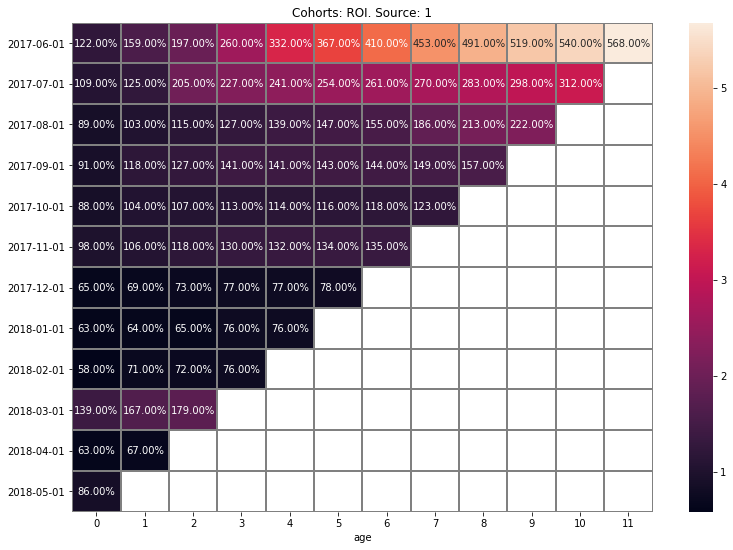

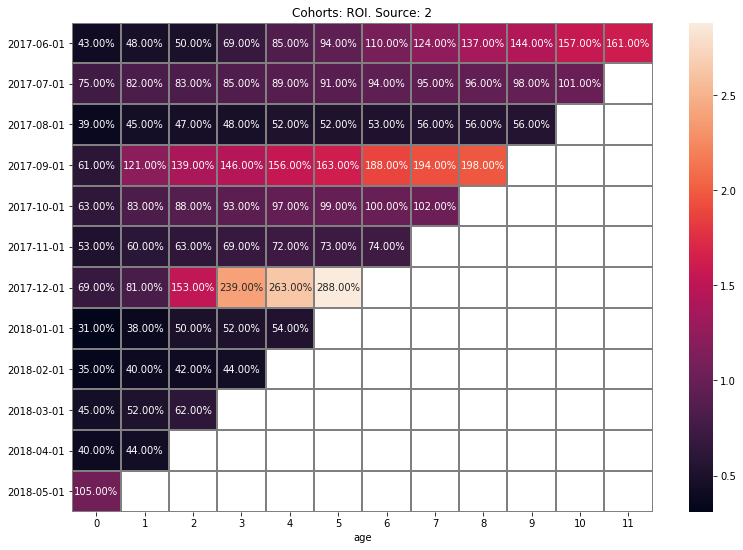

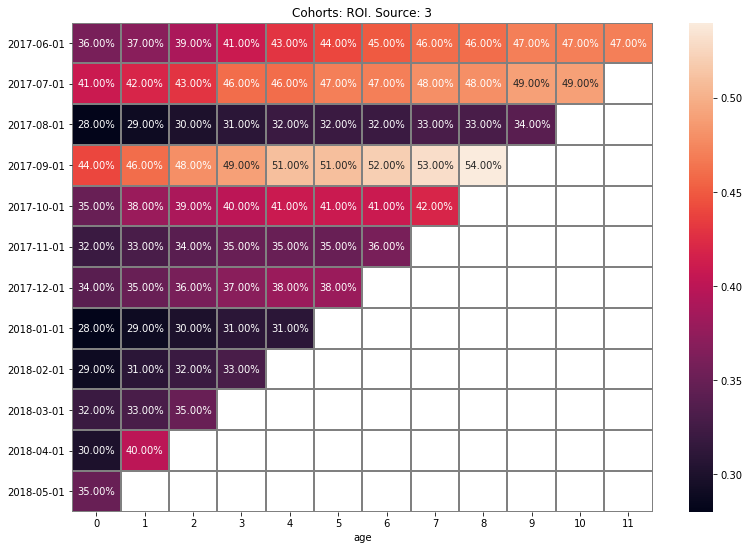

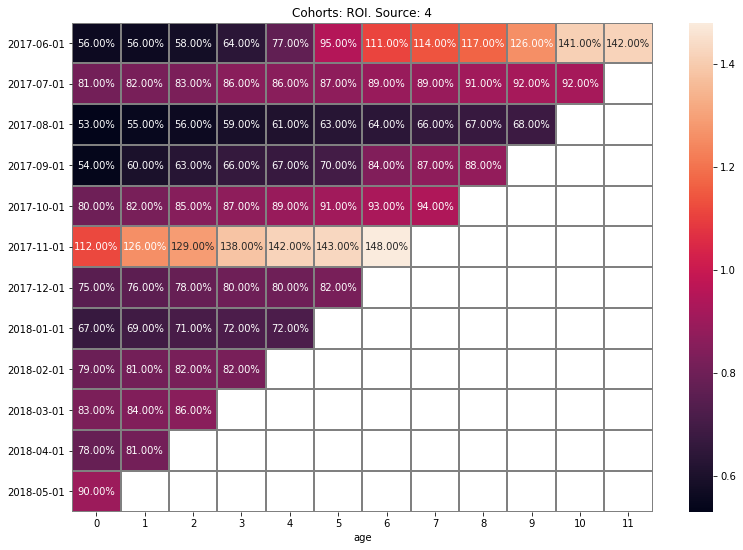

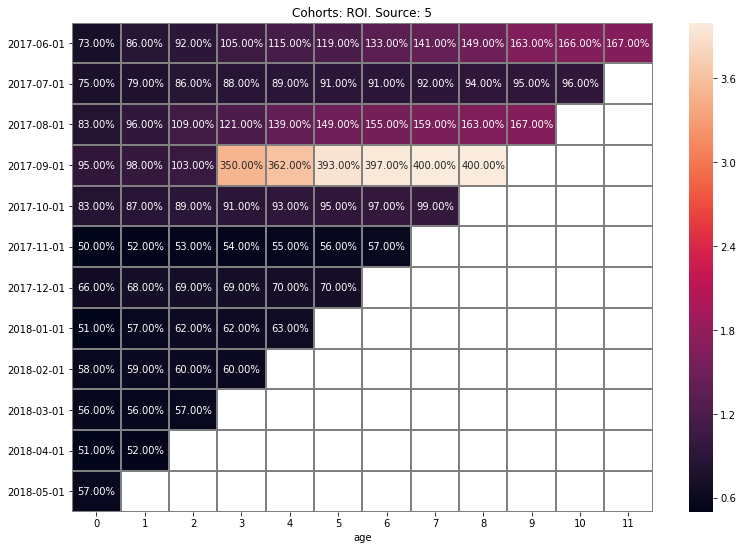

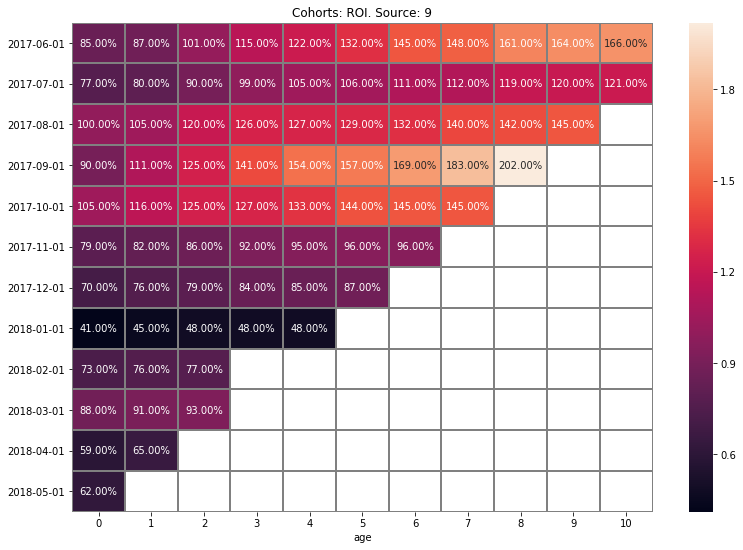

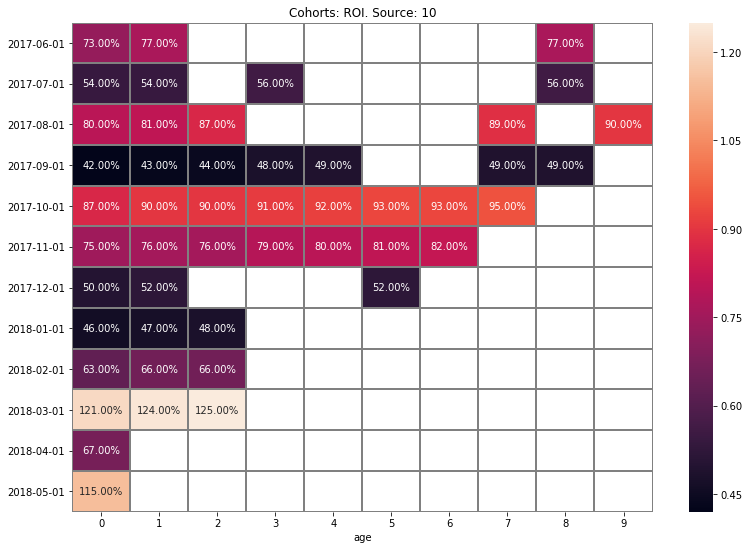

In [58]:
def show_heatmap(data):
    pivot = data.pivot_table(index = 'first_order_month', columns = 'age', values = 'roi', aggfunc = 'sum')
    pivot.index = pivot.index.date
    pivot = pivot.cumsum(axis=1).round(2)
    plt.figure(figsize=(13, 9))
    plt.title('Cohorts: ROI. Source: {}'.format(data.name))
    sns.heatmap(pivot, annot=True, fmt='.2%', linewidths=1, linecolor='gray');
    
cohorts.groupby('source_id').apply(show_heatmap)

- 1 источник хорошо окупался до декабря, на 1-2 месяц после вложений. Вложения в июне были самые прибыльные, за год ROI = 568%. Мартовская когорта тоже дала хорошую окупаемость, 179% на 3 месяц
- У 2 источника маскимальная окупаемость была от вложений в декабре (288 %). Примерно половина вложений не окупила себя
- По 3 источнику ни вышли на окупаемость ни в один из месяцев
- По 4 источнику только от вложений двух месяцев вышли на окупаемость. Максимальный ROI = 148% на 7 месяц вложений
- По 5 источнику только от вложений трех месяцев вышли на окупаемость.Резкий скачок ROI был у сентябрьской когорты в декабре. Он вырос со 103 до 350%. Максимальный ROI по источнику 400%
- По 9 источнику быстро рос ROI для когорт  с июня по октябрь. Выходили на окупаемость на 2- 5 месяц. Максимальная окупаемость была у сентябрьской когорты - 202%
- По 10 источнику вышли на окупаемость только для когорты марта и мая. Максимальный ROI(125%)

### Вывод

Всего на привлечение пользователей потратили 329 131  у.е. В среднем в месяц тратим на привлечение - 27 428 у.е. В среднем потратили на привлечение из одного источника 47 019 у.е. Больше всего потратили на привлечение пользователей через источник 3, меньше всего на источник 9. Больше всего потратили на привлечение пользователей в декабре и меньше всего в августе.  

В среднем тратим на привлечение одного пользователя 8 у.е. Больше всего стоит привлечение одного пользователя через источник 2 , меньше всего - через источник 10  

- 1 источник хорошо окупался до декабря, на 1-2 месяц после вложений. Вложения в июне были самые прибыльные, за год ROI = 568%. Мартовская когорта тоже дала хорошую окупаемость, 179% на 3 месяц
- У 2 источника маскимальная окупаемость была от вложений в декабре (288 %). Примерно половина вложений не окупила себя
- По 3 источнику ни вышли на окупаемость ни в один из месяцев
- По 4 источнику только от вложений двух месяцев вышли на окупаемость. Максимальный ROI = 148% на 7 месяц вложений
- По 5 источнику только от вложений трех месяцев вышли на окупаемость.Резкий скачок ROI был у сентябрьской когорты в декабре. Он вырос со 103 до 350%. Максимальный ROI по источнику 400%
- По 9 источнику быстро рос ROI для когорт  с июня по октябрь. Выходили на окупаемость на 2- 5 месяц. Максимальная окупаемость была у сентябрьской когорты - 202%
- По 10 источнику вышли на окупаемость только для когорты марта и мая. Максимальный ROI(125%)

### <a id="step3"> Шаг 3. Рекомендации маркетологам</a>

Напишите вывод: порекомендуйте маркетологам, куда и сколько им стоит вкладывать денег?
Какие источники/платформы вы бы порекомендовали? Объясните свой выбор: на какие метрики вы ориентируетесь? Почему? Какие выводы вы сделали, узнав значение метрик?

- Мы знаем, что сессии с компьютера длиннее чем с телефона в два раза и то что сессий с компьютера было в 2.3 раза больше, отсюда можем сделать вывод, что на компьютере сервисом пользоваться удобнее и деньги стоит вклдывать в десктопную версию

- У нас низкая возвращаемость пользователей. Возможно, помогли бы письма с предложением купить билеты на концерт той же группы или того же направления, которые посещал пользователь или просто рассылка раз в месяц с информацией о самых интересных событиях

- Люди совершают свою первую покупку обычно в тот же день, что зашли в сервис. Больше всего покупок было совершено с октября по декабрь и самый большой пик был за две недели до нового года. Стоит больше вкладываться в рекламу в эти месяцы и сделать рассылку на уже существующих пользователей с предложением купить подарки. Летом - мало покупок и нет смысла вкладываться в эти месяцы в рекламу. Возможно, малое количество покупок  связано с летними отпусками.

- Средний чек в начале месяца выше чем в конце месяца кроме декабря, там пик приходится на конец месяца.
Самый высокий средний чек был в середине сентября, конце августа и середине марта
Самый низкий средний чек был в конце января и начале февраля   

Отсюда следует, что нет смысла вкладываться в рекламу в конце января и начале февраля и больше всего стоит вкладываться в  в середине сентября, конце августа и середине марта. Маркетинговые рассылки лучше делать в начале месяца, т.к люди делают обычно более большие покупки в этот период.

Посмотрим сколько стоил нам каждый из источников. Посчитаем средний roi для каждого из источников

In [59]:
info_by_source['roi'] = (info_by_source['ltv'] / info_by_source ['cac'] ) * 100

In [60]:
display(info_by_source.sort_values(by = 'roi'))

,source_id,revenue,buyers_qty,ltv,costs,cac,roi
2,3,54511.24,10473,5.20,141321.63,13.49,38.547072
6,10,4450.33,1329,3.35,5822.49,4.38,76.484018
3,4,56696.83,10296,5.51,61073.60,5.93,92.917369
4,5,52624.02,6931,7.59,51757.10,7.47,101.606426
5,9,5759.40,1088,5.29,5517.49,5.07,104.339250
1,2,46923.61,3506,13.38,42806.04,12.21,109.582310
0,1,31090.55,2899,10.72,20833.27,7.19,149.095967


- Не стоит вкладывать деньги в источник 3, т.к. мы больше всего потратили на него денег и при этом не вышли на окупаемость ни в один из месяцев. В 4 и 10 тоже не стоит вкладывать в деньги, т.к. в среднем не выходим по ним на окупаемость   
Стоит вложить деньги в 9 источник, т.к. он стоил нам меньше всего, но дал окупаемость. Максимальный ROI  был у первого источника и он стоил нам 7 у.е. при максимальной цене в 13. По 2 и 5 источнику тоже вышли на окупаемость, тоже есть смысл вложить в них деньги

- Соответственно тому сколько стоит привлечение одного пользователя и возврата инвестиций можем предложить вложиться в рекламу по источникам в следующей пропорции:
- источник 1 - 50% рекламного бюджета
- источник 9 - 25% рекламного бюджета
- источник 2 - 12.5% рекламного бюджета
- Источник 5 - 12.5% рекламного бюджета